<a href="https://colab.research.google.com/github/angelg19/Satellite-Image-Analysis/blob/main/Pre_trained_model_satellite_imagery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.metrics import AUC
from tensorflow.keras.models import Model


# Import paths
train_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/train-jpg/train-jpg'
train_csv_file = '/content/drive/MyDrive/satellite_imagery/train_v2.csv'
test_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/test-jpg/test-jpg'
test_additional_jpeg_dir = '/content/drive/MyDrive/satellite_imagery/test-jpg-additional/test-jpg-additional'
img_resize = (128, 128)
validation_split = 0.2
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# Load labels
labels_df = pd.read_csv(train_csv_file)

# Find unique labels for class names
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))
labels_map = {label: idx for idx, label in enumerate(labels)}  # Map labels to indices
num_classes = len(labels_map)

# Turn labels to one-hot vectors
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)

# Train test validation splits
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [3]:
from PIL import Image

# Load and preprocess images
def _load_image(path_str):
    try:
        # Decode file path
        path_str = path_str.decode('utf-8')
        with Image.open(path_str) as img:
            img = img.convert('RGB')  # 3 color channels
            img = img.resize(img_resize)
            img_array = np.array(img).astype(np.float32) / 255.0
            return (img_array * 2.0) - 1.0  # Normalize input pixel shades to [-1, 1]
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

# Load and resize images
def load_and_preprocess_image_numpy(path, label):
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)
    image.set_shape([img_resize[0], img_resize[1], 3]) #3 color channels
    return image, label

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def augment_image(image, label):
    return data_augmentation(image), label

# Create dataset function
def create_dataset_numpy(df, image_dir, training=True):
    image_paths = df['image_name'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image_numpy, num_parallel_calls=AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1000).map(augment_image, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).prefetch(AUTOTUNE)

# Create training and validation datasets
train_dataset_numpy = create_dataset_numpy(train_df, train_jpeg_dir, training=True)
val_dataset_numpy = create_dataset_numpy(val_df, train_jpeg_dir, training=False)

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Unfreeze base model to train on our data

# Add custom classification head
x = base_model.output #take output from ResNet50 model
x = GlobalAveragePooling2D()(x) #reduce size a little
x = Dropout(0.5)(x) #prevent overfitting
x = Dense(256, activation='relu')(x) #ad non=linearity with ReLu
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='sigmoid')(x)  # Multi-label classification

model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy', #best for multilabel classification models
    metrics=[tf.keras.metrics.BinaryAccuracy(), AUC()] #binary accuracy measures accuracy for each class #AUC for imbalanced class accuracy
)

model.summary() #visualize ResNet layers and our added layers

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,116,625 (92.00 MB)

 Trainable params: 24,063,505 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [5]:
#training
history = model.fit(
    train_dataset_numpy,
    validation_data=val_dataset_numpy,
    epochs=10,
    verbose=1
)

Epoch 1/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 3049s 1s/step - auc: 0.7965 - binary_accuracy: 0.8003 - loss: 0.4522 - val_auc: 0.9713 - val_binary_accuracy: 0.9469 - val_loss: 0.1500
Epoch 2/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - auc: 0.9500 - binary_accuracy: 0.9307 - loss: 0.1896 - val_auc: 0.9792 - val_binary_accuracy: 0.9560 - val_loss: 0.1217
Epoch 3/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - auc: 0.9635 - binary_accuracy: 0.9430 - loss: 0.1599 - val_auc: 0.9823 - val_binary_accuracy: 0.9582 - val_loss: 0.1120
Epoch 4/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - auc: 0.9696 - binary_accuracy: 0.9483 - loss: 0.1455 - val_auc: 0.9842 - val_binary_accuracy: 0.9605 - val_loss: 0.1063
Epoch 5/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - auc: 0.9740 - binary_accuracy: 0.9521 - loss: 0.1345 - val_auc: 0.9847 - val_binary_accuracy: 0.9617 - val_loss: 0.1034
Epoch 6/10
2024/2024 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - auc: 0.9765 - binary_accuracy: 0.9542 - loss: 0.1276

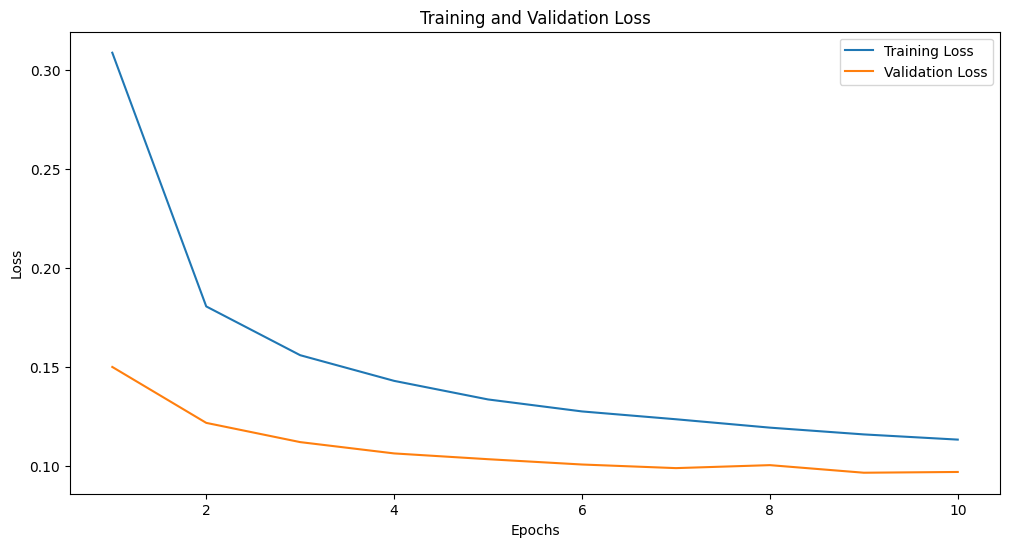

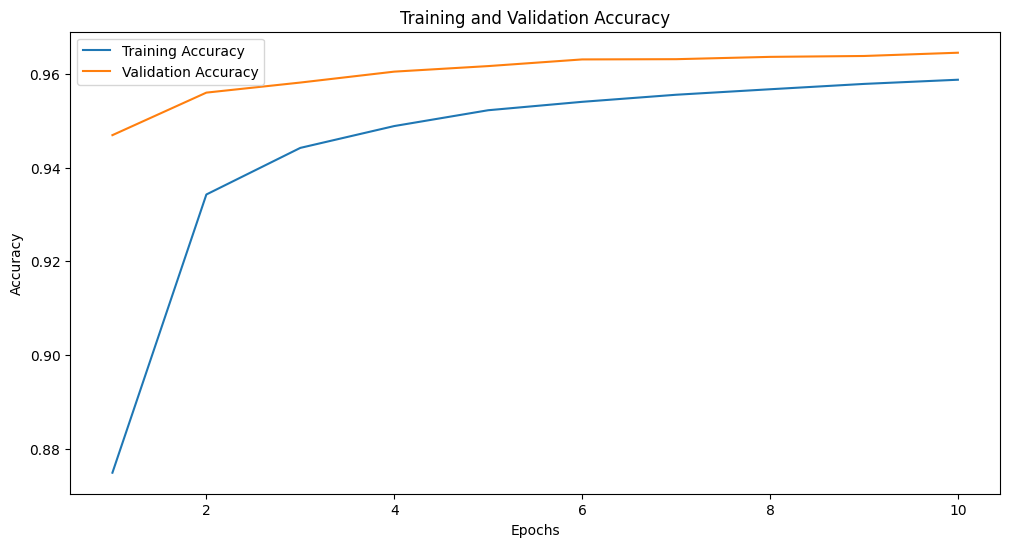

In [6]:
# Extract metrics from history
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['loss'], label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(epochs, history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


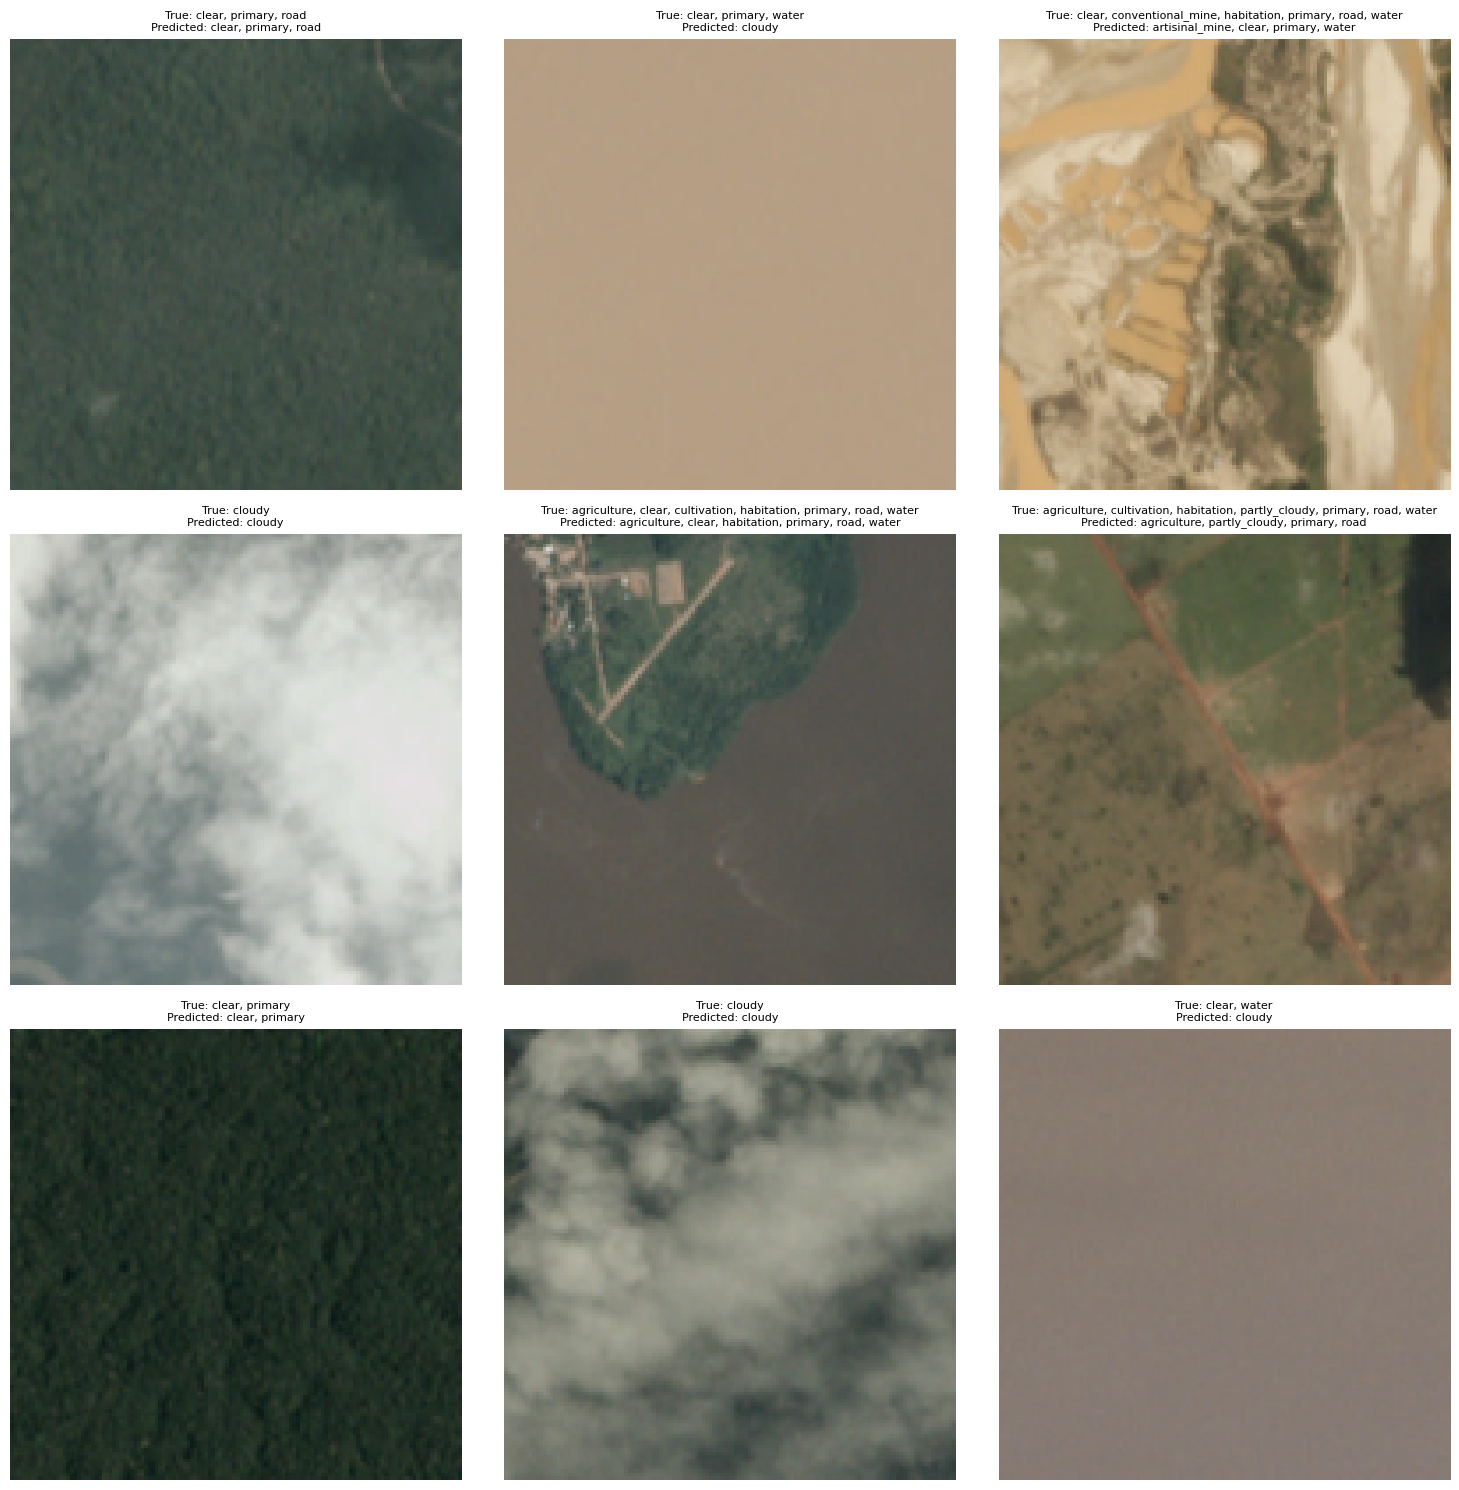

In [7]:
# Get a batch of validation data
for images, true_labels in val_dataset_numpy.take(1):
    predictions = model.predict(images)  # Predict probabilities for the batch

    # Decode predictions into binary labels (using threshold = 0.5)
    predicted_labels = (predictions > 0.5).astype(int)

    # Plot the images with predictions
    plt.figure(figsize=(15, 15))
    for i in range(9):  # Display first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() + 1) / 2.0)  # Denormalize image to [0, 1]
        plt.axis('off')
        true_label_text = ", ".join([label for label, present in zip(labels_map.keys(), true_labels[i]) if present])
        predicted_label_text = ", ".join([label for label, present in zip(labels_map.keys(), predicted_labels[i]) if present])
        plt.title(f"True: {true_label_text}\nPredicted: {predicted_label_text}", fontsize=8)
    plt.tight_layout()
    plt.show()

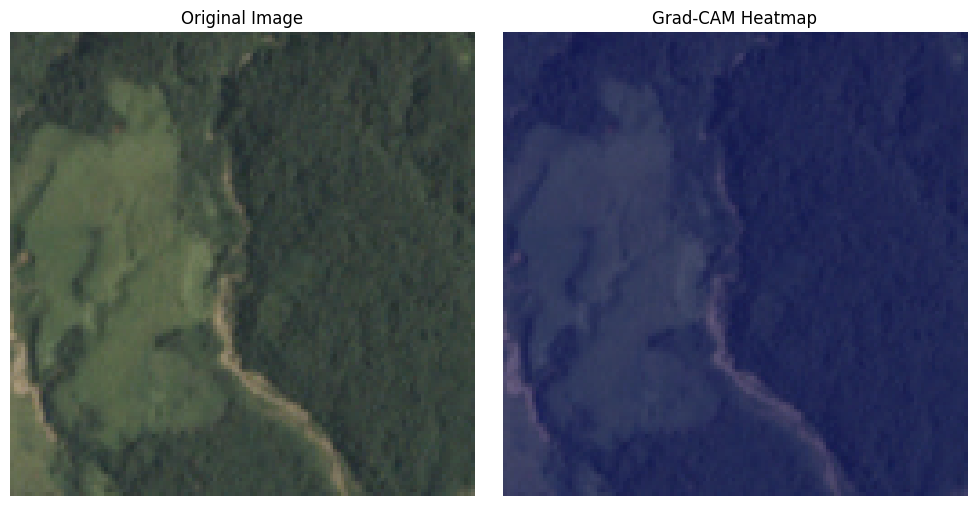

In [39]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Get the last convolutional layer and build the Grad-CAM model
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_class = tf.argmax(predictions[0])  # Focus on the top predicted class
        loss = predictions[:, top_class]

    # Calculate gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs[0], axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap + 1e-8)  # Add small value to avoid division by zero
    return heatmap

def display_gradcam(img_path, model, last_conv_layer_name):
    # Load image
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img)  # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create a batch
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    # Display original image
    original_img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize for display

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap to image size
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (128, 128)).numpy().squeeze()

    # Overlay heatmap on image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_img)  # Display original image
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(original_img)
    axes[1].imshow(heatmap_resized, cmap='jet', alpha=0.4)  # Grad-CAM heatmap overlay
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Apply Grad-CAM
# Try different layers, for example: 'conv4_block6_out', 'conv5_block3_out', etc.
display_gradcam(
    img_path='/content/drive/MyDrive/satellite_imagery/train-jpg/train-jpg/train_1.jpg',
    model=model,
    last_conv_layer_name='conv4_block6_out'  # Change the layer name here
)


In [66]:
# Extract image_name from img_path
img_path = '/content/drive/MyDrive/satellite_imagery/train-jpg/train-jpg/train_1.jpg'
image_name = img_path.split('/')[-1].split('.')[0]  # Result: 'train_1'

def get_ground_truth(image_name, labels_df, labels_map):
    """
    Get the one-hot encoded ground truth for an image.

    Args:
        image_name (str): The name of the image (e.g., 'train_1').
        labels_df (pd.DataFrame): The DataFrame containing image names and tags.
        labels_map (dict): A mapping of label names to indices.

    Returns:
        list: One-hot encoded ground truth labels for the image.
    """
    # Find the row in labels_df corresponding to the image_name
    row = labels_df[labels_df['image_name'] == image_name]

    if row.empty:
        print(f"No ground truth found for image: {image_name}")
        return [0] * len(labels_map)  # Return all-zero one-hot encoding if not found

    # Extract tags and encode them
    tags = row['tags'].values[0].split()  # Get tags as a list of strings
    ground_truth = [1 if label in tags else 0 for label in labels_map.keys()]  # One-hot encode

    return ground_truth

# Example usage
ground_truth_labels = get_ground_truth(image_name, labels_df, labels_map)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


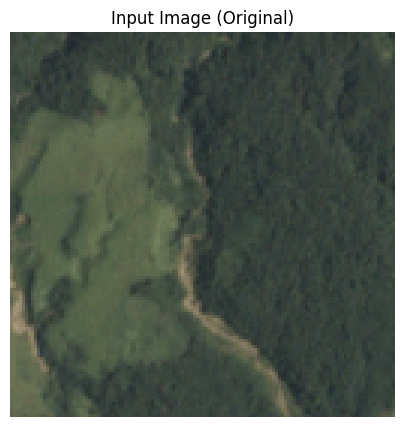

Predictions:
agriculture: 0.0000
artisinal_mine: 0.0000
bare_ground: 0.0000
blooming: 0.0000
blow_down: 0.0000
clear: 1.0000
cloudy: 0.0000
conventional_mine: 0.0000
cultivation: 0.0000
habitation: 0.0000
haze: 0.0000
partly_cloudy: 0.0000
primary: 1.0000
road: 0.0000
selective_logging: 0.0000
slash_burn: 0.0000
water: 1.0000

Ground Truth:
agriculture
clear
primary
water


In [67]:
def show_image_and_predictions(img_path, model, class_labels, ground_truth_labels):
    import matplotlib.pyplot as plt

    # Load the original image (PIL Image)
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))  # Load as PIL image

    # Convert the image to NumPy array for processing
    img_array = tf.keras.utils.img_to_array(img)  # Convert to NumPy array

    # Normalize the image for the model
    input_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    input_array = tf.keras.applications.resnet50.preprocess_input(input_array)  # Normalize for ResNet

    # Get predictions from the model
    predictions = model.predict(input_array)

    # Display the original, unprocessed image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)  # Directly display the original PIL image
    plt.axis('off')
    plt.title("Input Image (Original)")
    plt.show()

    # Print predictions
    print("Predictions:")
    for i, score in enumerate(predictions[0]):
        print(f"{class_labels[i]}: {score:.4f}")

    # Print ground truth
    if ground_truth_labels is not None:
        print("\nGround Truth:")
        for i, label in enumerate(ground_truth_labels):
            if label == 1:
                print(f"{class_labels[i]}")

# Example usage:
show_image_and_predictions(
    img_path=img_path,  # Path to the image
    model=model,
    class_labels=class_labels,
    ground_truth_labels=ground_truth_labels
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

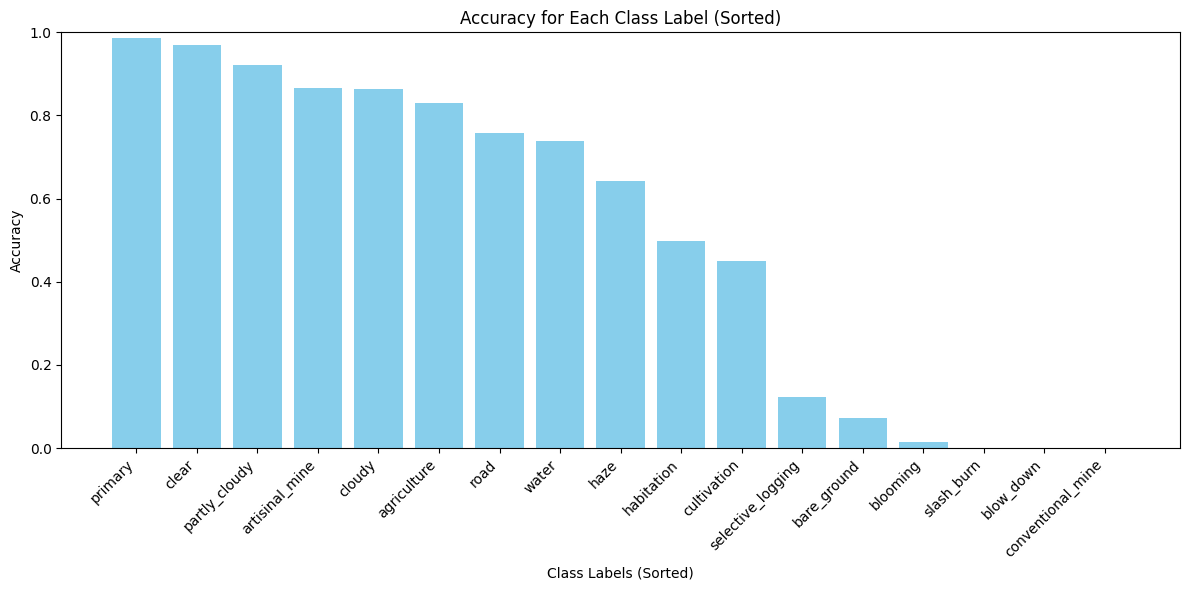

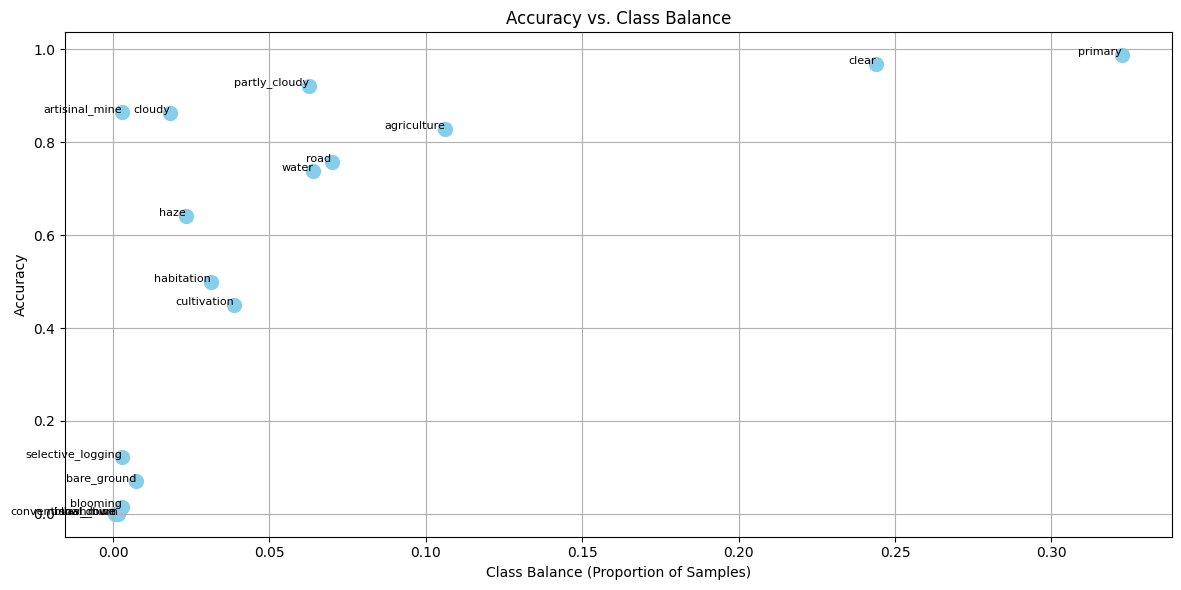

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_class_accuracy_and_balance(model, dataset, class_labels):
    """
    Calculate the accuracy and balance (class proportions) for each class label.
    Args:
        model: Trained model.
        dataset: Dataset (images and ground truth labels).
        class_labels: List of class label names.
    Returns:
        accuracies: List of accuracy values for each class.
        balances: List of class balance (proportions) for each class.
    """
    total_per_class = np.zeros(len(class_labels))
    correct_per_class = np.zeros(len(class_labels))

    # Iterate over the dataset
    for images, ground_truth in dataset:
        predictions = model.predict(images)

        # Convert predictions to binary (0 or 1) for multi-label classification
        binary_predictions = (predictions > 0.5).astype(int)

        # Update totals and correct counts
        total_per_class += np.sum(ground_truth, axis=0)
        correct_per_class += np.sum((binary_predictions == ground_truth) & (ground_truth == 1), axis=0)

    # Calculate accuracy for each class
    accuracies = correct_per_class / total_per_class

    # Calculate class balances
    balances = total_per_class / np.sum(total_per_class)

    return accuracies, balances

def plot_sorted_class_accuracy(accuracies, class_labels):
    """
    Plot the accuracy for each class label, sorted from highest to lowest.
    Args:
        accuracies: List of accuracy values for each class.
        class_labels: List of class label names.
    """
    # Sort accuracies and class labels
    sorted_indices = np.argsort(accuracies)[::-1]
    sorted_accuracies = accuracies[sorted_indices]
    sorted_labels = [class_labels[i] for i in sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_labels, sorted_accuracies, color='skyblue')
    plt.xlabel("Class Labels (Sorted)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Each Class Label (Sorted)")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def plot_accuracy_vs_balance(accuracies, balances, class_labels):
    """
    Plot accuracy vs. class balance for each class.
    Args:
        accuracies: List of accuracy values for each class.
        balances: List of class balance (proportions) for each class.
        class_labels: List of class label names.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(balances, accuracies, color='skyblue', s=100)

    # Annotate points with class labels
    for i, label in enumerate(class_labels):
        plt.text(balances[i], accuracies[i], label, fontsize=8, ha='right')

    plt.xlabel("Class Balance (Proportion of Samples)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Class Balance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
accuracies, balances = calculate_class_accuracy_and_balance(model, train_dataset_numpy, class_labels)

# Plot sorted class accuracy
plot_sorted_class_accuracy(accuracies, class_labels)

# Plot accuracy vs. class balance
plot_accuracy_vs_balance(accuracies, balances, class_labels)
